In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, r2_score

In [39]:
df = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/individual_book_train/stock_0.csv")

In [40]:
def make_features(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()
    # 1. mid_price & spread
    df['mid_price'] = (df['bid_price1'] + df['ask_price1']) / 2
    df['spread']    = df['ask_price1'] - df['bid_price1']
    
    # 2. imbalance & book_pressure & microprice
    with np.errstate(divide='ignore', invalid='ignore'):
        num  = df['bid_size1'] - df['ask_size1']
        den  = df['bid_size1'] + df['ask_size1']
        df['imbalance'] = np.where(den > 0, num / den, np.nan)

        num2 = (df['bid_size1'] + df['bid_size2']) - (df['ask_size1'] + df['ask_size2'])
        den2 = df[['bid_size1','bid_size2','ask_size1','ask_size2']].sum(axis=1)
        df['book_pressure'] = np.where(den2 > 0, num2 / den2, np.nan)

        num3 = (df['ask_price1'] * df['bid_size1'] +
                df['bid_price1'] * df['ask_size1'])
        df['microprice'] = np.where(den > 0, num3 / den, np.nan)

    # 3. normalized_spread & L2 OBI
    df['normalized_spread'] = df['spread'] / df['mid_price'].replace(0, np.nan)
    df['OBI_L2'] = np.where(den2 > 0, (df['bid_size1'] + df['bid_size2']) / den2, np.nan)

    # 4. LOB entropy
    sizes = df[['bid_size1','bid_size2','ask_size1','ask_size2']].astype(float).values
    total = sizes.sum(axis=1, keepdims=True)
    p = np.divide(sizes, total, where=total != 0)
    entropy = -np.nansum(np.where(p > 0, p * np.log(p), 0), axis=1)
    df['LOB_entropy'] = entropy
    df['LOB_entropy_normalized'] = entropy / np.log(4)

    # 5. log returns
    df['log_return'] = (
        df.groupby('time_id')['mid_price']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 6. Realized volatility (safe: no leakage)

    df['realized_volatility'] = (
        df.groupby('time_id')['log_return']
        .transform(lambda x: np.sqrt(
            ((x.shift(1) ** 2)
                .rolling(30, min_periods=1)
                .sum()
            ).clip(lower=0)
        ))
    )

    # TARGET
    df['rv_future'] = (
        df.groupby('time_id')['realized_volatility'].shift(-30)   
    )

    # 7. Bipower variance (safe: no leakage)
    df['bipower_var'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.abs().shift(1)
                       .rolling(2, min_periods=1)
                       .apply(lambda r: r[0] * r[1], raw=True)
                       .rolling(30, min_periods=1)
                       .mean())
    )

    # 8. WAP and its log return
    df['wap'] = (
        (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) /
        (df['bid_size1'] + df['ask_size1']).replace(0, np.nan)
    )
    df['log_wap_return'] = (
        df.groupby('time_id')['wap']
          .transform(lambda x: np.log(x / x.shift(1)))
    )

    # 9. Lag features (safe)
    for col in ['imbalance', 'book_pressure', 'log_return']:
        df[f'{col}_lag1'] = df.groupby('time_id')[col].shift(1)
        df[f'{col}_lag2'] = df.groupby('time_id')[col].shift(2)

    # 10. Rolling stats (safe)
    df['rolling_vol_30'] = (
        df.groupby('time_id')['log_return']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).std())
    )
    df['rolling_imbalance_mean_30'] = (
        df.groupby('time_id')['imbalance']
          .transform(lambda x: x.shift(1).rolling(30, min_periods=1).mean())
    )

    df = df.dropna()   
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

In [41]:
df = make_features(df)

In [42]:
def add_time_features(df_enriched: pd.DataFrame, period: int = 600):

    theta = 2 * np.pi * df_enriched['seconds_in_bucket'] / period
    df_enriched['sec_sin'] = np.sin(theta)
    df_enriched['sec_cos'] = np.cos(theta)

    return df_enriched.drop(columns=["seconds_in_bucket"])

df = add_time_features(df)

In [43]:
for c in ['bid_size1','ask_size1','bid_size2','ask_size2']:
    df[c + '_log'] = np.log1p(df[c])
    df.drop(columns=c, inplace=True)

In [44]:
feature_cols_mod = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2',
       'stock_id', 'mid_price', 'spread', 'imbalance', 'book_pressure',
       'microprice', 'normalized_spread', 'OBI_L2', 'LOB_entropy',
       'LOB_entropy_normalized', 'log_return', 'realized_volatility', 'bipower_var', 'wap', 'log_wap_return', 'imbalance_lag1',
       'imbalance_lag2', 'book_pressure_lag1', 'book_pressure_lag2',
       'log_return_lag1', 'log_return_lag2', 'rolling_vol_30',
       'rolling_imbalance_mean_30', 'sec_sin', 'sec_cos', 'bid_size1_log',
       'ask_size1_log', 'bid_size2_log', 'ask_size2_log']
target_col = "rv_future"

df['rv_future_log'] = np.log1p(df[target_col])
target_col_mod   = 'rv_future_log'

In [45]:
unique_sessions = np.sort(df['time_id'].unique())
split_idx       = int(len(unique_sessions) * 0.8)

train_val_sessions = unique_sessions[:split_idx]
test_sessions      = unique_sessions[split_idx:]

train_val_df = df[df['time_id'].isin(train_val_sessions)].copy()
test_df      = df[df['time_id'].isin(test_sessions)].copy()

In [46]:
x_scaler = MinMaxScaler().fit(train_val_df[feature_cols_mod])
y_scaler = MinMaxScaler().fit(train_val_df[[target_col_mod]])

for _df in (train_val_df, test_df):
    _df[feature_cols_mod] = x_scaler.transform(_df[feature_cols_mod])
    _df[target_col_mod]   = y_scaler.transform(_df[[target_col_mod]])

In [47]:
val_cut        = int(len(train_val_sessions) * 0.9)
train_sessions = train_val_sessions[:val_cut]
val_sessions   = train_val_sessions[val_cut:]

train_df = train_val_df[train_val_df['time_id'].isin(train_sessions)]
val_df   = train_val_df[train_val_df['time_id'].isin(val_sessions)]

In [48]:
X_train = train_df[feature_cols_mod].values
y_train = train_df[target_col_mod].values.ravel()

X_val   = val_df[feature_cols_mod].values
y_val   = val_df[target_col_mod].values.ravel()

X_test  = test_df[feature_cols_mod].values
y_test  = test_df[target_col_mod].values.ravel()

In [49]:
SEQ_LEN = 30

In [50]:
# Unique
def build_sequences(df_part: pd.DataFrame,
                    feature_cols: list[str],
                    target_col: str,
                    seq_len: int):
    X, y = [], []
    for _, session in df_part.groupby("time_id"):
        data   = session[feature_cols].values
        target = session[target_col].values
        for i in range(len(session) - seq_len):
            X.append(data[i : i + seq_len])
            y.append(target[i + seq_len])
    return np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.float32)

X_train, y_train = build_sequences(train_df, feature_cols_mod, target_col_mod, SEQ_LEN)
X_val,   y_val   = build_sequences(val_df,   feature_cols_mod, target_col_mod, SEQ_LEN)
X_test,  y_test  = build_sequences(test_df,  feature_cols_mod, target_col_mod, SEQ_LEN)

In [51]:
def build_baseline_hav_model(seq_len: int, n_features: int):
    inputs = layers.Input(shape=(seq_len, n_features))

    x = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)

    attn_out = layers.MultiHeadAttention(num_heads=2, key_dim=x.shape[-1])(x, x)
    x = layers.Add()([x, attn_out])
    x = layers.LayerNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1, activation='linear')(x)
    return models.Model(inputs, outputs, name="HAV_baseline")

In [52]:
hav_baseline = build_baseline_hav_model(SEQ_LEN, X_train.shape[-1])
hav_baseline.compile(optimizer='adam', loss='mse')

In [53]:
early_stop = callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)
history = hav_baseline.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),     
    epochs=50,
    batch_size=32,
    shuffle=False,                      
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
15283/15283 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - loss: 0.0093 - val_loss: 0.0017
Epoch 2/50
15283/15283 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 3/50
15283/15283 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 4/50
15283/15283 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 5/50
15283/15283 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 6/50
15283/15283 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 7/50
15283/15283 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 8/50
15283/15283 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 9/50
15283/15283 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 10/50
15283/15283 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 11/50
15283/15283 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step - loss: 0.0013 - val_loss: 0.00

In [58]:
y_pred_log    = hav_baseline.predict(X_test).flatten()
y_true_log    = y_test  

y_pred_log    = y_scaler.inverse_transform(y_pred_log .reshape(-1,1)).flatten()
y_true_log    = y_scaler.inverse_transform(y_true_log.reshape(-1,1)).flatten()

y_pred_raw = np.expm1(y_pred_log)
y_true_raw = np.expm1(y_true_log)

4168/4168 ━━━━━━━━━━━━━━━━━━━━ 2s 540us/step


In [59]:
rmse = root_mean_squared_error(y_true_raw, y_pred_raw)
r2   = r2_score(y_true_raw, y_pred_raw)

def qlike_safe(actual, forecast, eps=1e-8):
    a = np.clip(actual,   eps, None)
    f = np.clip(forecast, eps, None)
    r = a / f
    return np.mean(r - np.log(r) - 1.0)

ql = qlike_safe(y_true_raw, y_pred_raw)

print(f"Out‑of‑sample RMSE: {rmse:.6f}")
print(f"R² score         : {r2:.6f}")
print(f"QLIKE            : {ql:.6f}")

Out‑of‑sample RMSE: 0.000478
R² score         : 0.471797
QLIKE            : 0.145672


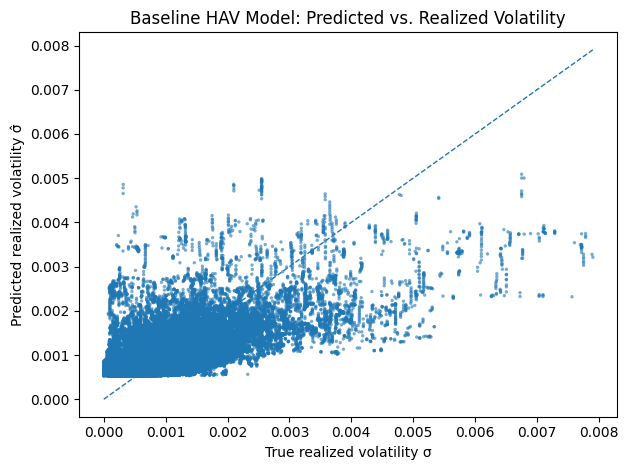

In [60]:
plt.figure()
plt.scatter(y_true_raw, y_pred_raw, s=6, alpha=0.6, edgecolor="none")
max_val = max(y_true_raw.max(), y_pred_raw.max())
plt.plot([0, max_val], [0, max_val], "--", linewidth=1)
plt.title("Baseline HAV Model: Predicted vs. Realized Volatility")
plt.xlabel("True realized volatility σ")
plt.ylabel("Predicted realized volatility σ̂")
plt.tight_layout()
plt.show()

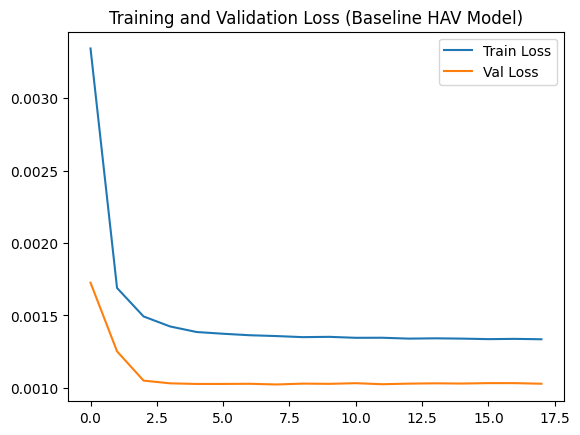

In [61]:
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training and Validation Loss (Baseline HAV Model)")
plt.legend()
plt.show()